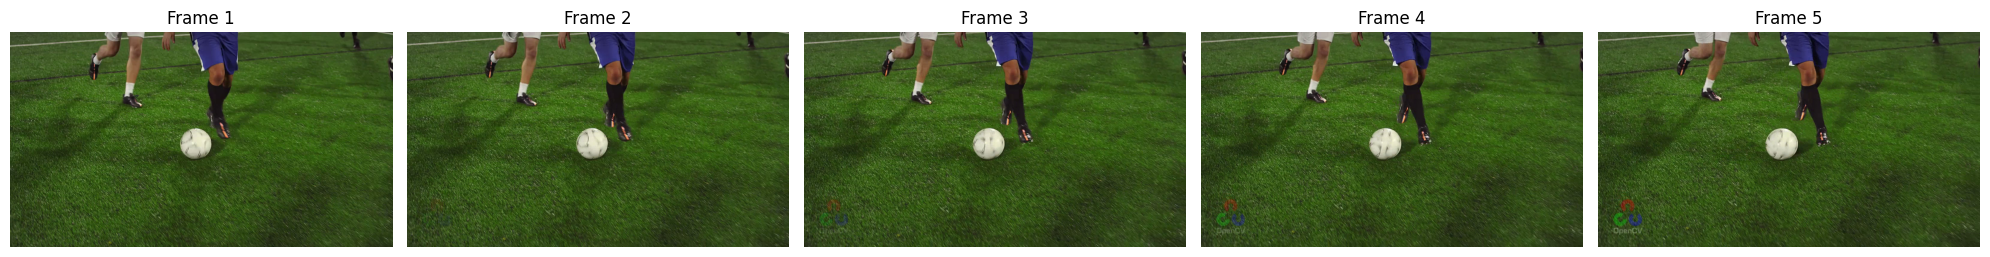

In [6]:
import cv2
import matplotlib.pyplot as plt

video_path = "soccer-ball.mp4"
cap = cv2.VideoCapture(video_path)

frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
fps = cap.get(cv2.CAP_PROP_FPS)
success, frame = cap.read()
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
frames_to_display = 5
frames = []

if success:
    for i in range(frames_to_display):
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)  
        frames.append(frame)
        success, frame = cap.read()
else:
    frames = None

cap.release()
test_frame = frames[0]

if frames:
    fig, axes = plt.subplots(1, frames_to_display, figsize=(20, 5))
    for i, ax in enumerate(axes):
        ax.imshow(frames[i])
        ax.axis("off")
        ax.set_title(f"Frame {i+1}")
    plt.tight_layout()
    plt.show()
else:
    print("Could not read frames from the video.")


0: 384x640 1 sports ball, 47.4ms
Speed: 2.0ms preprocess, 47.4ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


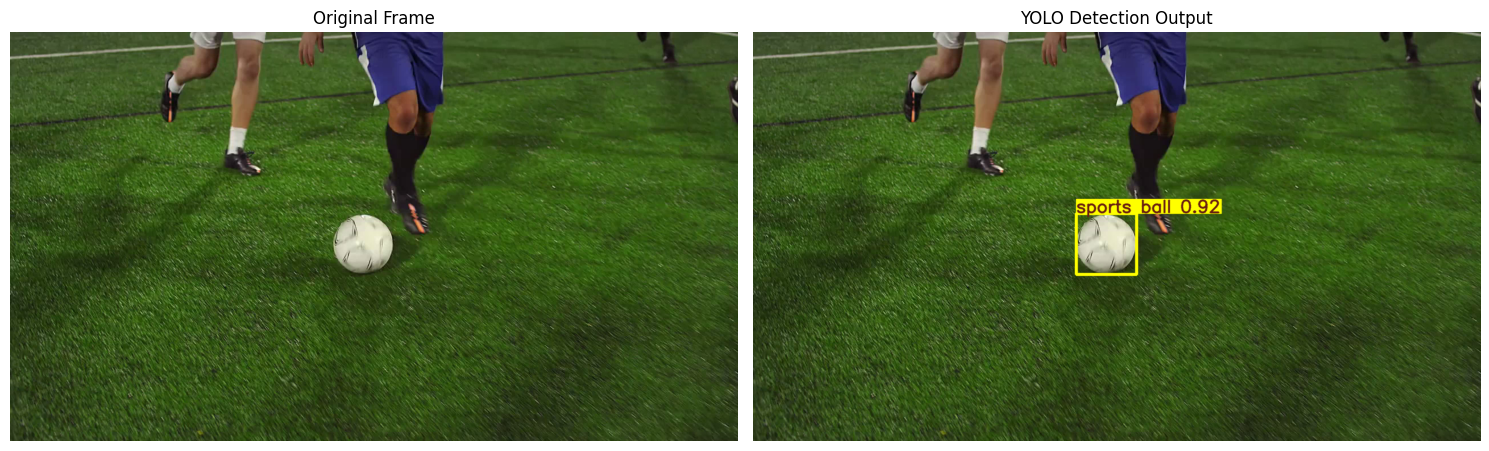

In [7]:
from ultralytics import YOLO


model = YOLO('yolov8n.pt')
results = model.predict(source=test_frame, conf=0.89)  

    
detected_frame = results[0].plot()
fig, ax = plt.subplots(1, 2, figsize=(15, 7))
ax[0].imshow(test_frame)
ax[0].set_title("Original Frame")
ax[0].axis("off")
ax[1].imshow(cv2.cvtColor(detected_frame, 0))
ax[1].set_title("YOLO Detection Output")
ax[1].axis("off")
plt.tight_layout()
plt.show()



In [13]:
import numpy as np
import time

blue = (255,128,0)
class ObjectTracker:
    def __init__(self, video_path, model_path='yolov8n.pt', confidence=0.9):
        self.model = YOLO(model_path)
        self.cap = cv2.VideoCapture(video_path)
        self.confidence = confidence
        self.tracker = cv2.TrackerCSRT_create()
        self.tracking_initialized = False
        self.frame_width = int(self.cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        self.frame_height = int(self.cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    def is_ball_in_frame(self, bbox):
        x, y, w, h = bbox
        frame_margin = 50  # Pixel margin around frame edges
        return (frame_margin < x < self.frame_width - frame_margin and
                frame_margin < y < self.frame_height - frame_margin)

    def detect_ball(self, frame):
        results = self.model.predict(source=frame, conf=self.confidence)
        ball_boxes = [box for box in results[0].boxes if self.is_ball_candidate(box)]
        return ball_boxes

    def is_ball_candidate(self, box):
        class_name = self.model.names[int(box.cls)]
        area = (box.xyxy[0][2] - box.xyxy[0][0]) * (box.xyxy[0][3] - box.xyxy[0][1])
        return (class_name == 'sports ball' or 
                class_name in ['ball', 'soccer ball']) and area > 100

    def detect_and_track(self):
        detection_times, tracking_times = [], []
        while True:
            ret, frame = self.cap.read()
            timer = cv2.getTickCount()
            fps = cv2.getTickFrequency() / (cv2.getTickCount() - timer);
            if not ret:
                break

            if not self.tracking_initialized:
                det_start = time.time()
                               
                ball_candidates = self.detect_ball(frame)
                det_end = time.time()
                detection_time = det_end - det_start
                detection_times.append(detection_time)
                if ball_candidates:
                    best_ball = max(ball_candidates, key=lambda box: box.conf)
                    bbox = best_ball.xyxy[0].cpu().numpy().astype(int)
                    x, y, x2, y2 = bbox
                    
                    # Yellow detection box
                    cv2.rectangle(frame, (x, y), (x2, y2), (0, 255, 255), 2)
                    
                    self.current_bbox = (x, y, x2-x, y2-y)
                    self.tracker.init(frame, self.current_bbox)
                    self.tracking_initialized = True

            if self.tracking_initialized:
                track_start = time.time()
                success, self.current_bbox = self.tracker.update(frame)
                track_end = time.time()
                tracking_time = track_end - track_start
                tracking_times.append(tracking_time)
                if success and self.is_ball_in_frame(self.current_bbox):
                    x, y, w, h = [int(v) for v in self.current_bbox]
                    # Green tracking box
                    cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)
               
                else:
                    # Reset tracking if ball is out of frame
                    self.tracking_initialized = False
                    cv2.putText(frame, "TRACKING LOST", (10, 120), 
                                cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 255), 3)
            cv2.putText(frame, 
                        f"Detection Avg: {np.mean(detection_times)*1000:.2f}ms", 
                        (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
            cv2.putText(frame, 
                        f"Tracking Avg: {np.mean(tracking_times)*1000:.2f}ms", 
                        (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
            cv2.putText(frame, 
                        f"FPS: {(int(fps)/10000)}", 
                        (10, 90), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 0, 0), 2)
            
            cv2.imshow('Smart Ball Tracking', frame)

            if cv2.waitKey(1) & 0xFF == ord('q'):
                break

        self.cap.release()
        cv2.destroyAllWindows()

# Run the tracker
tracker = ObjectTracker('soccer-ball.mp4')
tracker.detect_and_track()


0: 384x640 1 sports ball, 45.6ms
Speed: 1.5ms preprocess, 45.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 46.1ms
Speed: 1.0ms preprocess, 46.1ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 50.5ms
Speed: 2.0ms preprocess, 50.5ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 52.2ms
Speed: 2.0ms preprocess, 52.2ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 55.7ms
Speed: 2.0ms preprocess, 55.7ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 62.7ms
Speed: 3.0ms preprocess, 62.7ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 57.1ms
Speed: 2.0ms preprocess, 57.1ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 47.6ms
Speed: 2.0ms preprocess, 47.6ms inference, 1.0ms postprocess p